In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Load dataset
# ================================
df = pd.read_csv("exoplanets_clean_full.csv")

# ================================
# Handle Missing Values (SAFE)
# ================================

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Fill numerical missing values with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical missing values with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# ================================
# Handle Inconsistent Entries
# ================================

# Remove extra spaces and standardize text
for col in cat_cols:
    df[col] = df[col].str.strip().str.lower()

# ================================
# Handle Outliers using IQR Method
# ================================
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

for col in num_cols:
    df = remove_outliers_iqr(df, col)

# ================================
# Remove duplicate rows
# ================================
df = df.drop_duplicates()



In [2]:
# One-Hot Encoding

# Convert categorical feature 'st_spectype' into numerical form
# drop_first=True avoids dummy variable trap
df = pd.get_dummies(df, columns=["st_spectype"], drop_first=True)



In [3]:
# Two engineered features:

# =========================================
# Habitability Score Index (HSI)
# =========================================

# Normalize selected planetary parameters (0–1)
df["radius_norm"] = (df["pl_rade"] - df["pl_rade"].min()) / (df["pl_rade"].max() - df["pl_rade"].min())
df["temp_norm"] = (df["pl_eqt"] - df["pl_eqt"].min()) / (df["pl_eqt"].max() - df["pl_eqt"].min())
df["orbit_norm"] = (df["pl_orbper"] - df["pl_orbper"].min()) / (df["pl_orbper"].max() - df["pl_orbper"].min())

# Compute Habitability Score (higher = more habitable)
df["habitability_score"] = (
    0.4 * (1 - df["radius_norm"]) +
    0.4 * (1 - abs(df["temp_norm"] - 0.5)) +
    0.2 * (1 - df["orbit_norm"])
)


In [4]:
# =========================================
# Stellar Compatibility Index (SCI)
# =========================================

# Normalize stellar parameters
df["st_temp_norm"] = (df["st_teff"] - df["st_teff"].min()) / (df["st_teff"].max() - df["st_teff"].min())
df["st_radius_norm"] = (df["st_rad"] - df["st_rad"].min()) / (df["st_rad"].max() - df["st_rad"].min())
df["st_lum_norm"] = (df["st_lum"] - df["st_lum"].min()) / (df["st_lum"].max() - df["st_lum"].min())

# Compute Stellar Compatibility Index
df["stellar_compatibility_index"] = (
    0.4 * (1 - abs(df["st_temp_norm"] - 0.5)) +
    0.3 * (1 - df["st_radius_norm"]) +
    0.3 * (1 - df["st_lum_norm"])
)


In [5]:
# =========================================
# Earth Similarity Index (ESI)
# =========================================

df["earth_similarity_index"] = (
    (1 - abs(df["pl_rade"] - 1)) *
    (1 - abs(df["pl_eqt"] - 288) / 288)
)


In [6]:
# =========================================
# Planet Density Category
# =========================================

df["planet_density_type"] = np.where(
    df["pl_rade"] < 1.6, "rocky",
    np.where(df["pl_rade"] < 4, "super_earth", "gas_giant")
)


In [7]:


# Orbital Stability Index (already present)
# Higher value → more stable orbit
df["orbital_stability_index"] = 1 / (1 + df["pl_orbper_zs"].abs())



# Star–Planet Interaction Index
df["star_planet_interaction_index"] = (
    df["log_st_lum"] / (df["log_pl_orbsmax"] + 1)
)


In [8]:
# Distance Penalty Feature
df["distance_penalty"] = 1 / (1 + df["sy_dist"])
# Habitable Planet Label
df["habitable_label"] = np.where(
    (df["habitability_score"] > 0.6) &
    (df["stellar_compatibility_index"] > 0.6),
    1, 0
)


In [9]:
df[[
    "habitability_score",
    "stellar_compatibility_index",
    "earth_similarity_index",
    "orbital_stability_index",
    "star_planet_interaction_index",
    "habitable_label"
]].head()


,habitability_score,stellar_compatibility_index,earth_similarity_index,orbital_stability_index,star_planet_interaction_index,habitable_label
106,NaN,0.723515,0.212917,0.994234,0.568333,0
152,NaN,0.723515,0.212917,0.994237,0.568333,0
208,NaN,0.723515,0.212917,0.994234,0.568333,0
256,NaN,0.723515,0.212917,0.994234,0.568333,0
284,NaN,0.710146,0.212917,0.994234,0.539530,0


In [10]:


import numpy as np
from sklearn.preprocessing import StandardScaler

# Select numeric columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Remove target variable
if "habitable_label" in num_cols:
    num_cols.remove("habitable_label")

# Exclude indicator, flag, and already-normalized columns
exclude_patterns = (
    "_missing", "_outlier", "_zs",
    "radius_norm", "temp_norm", "orbit_norm"
)

num_cols = [
    col for col in num_cols
    if not any(pat in col for pat in exclude_patterns)
]

# Remove zero-variance columns (std = 0)
num_cols = [
    col for col in num_cols
    if df[col].std() != 0
]

# Replace any inf values just in case
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

# Fill any remaining NaNs with column median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Apply StandardScaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])



c:\Users\k8710\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\k8710\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\k8710\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [11]:
# =========================================
# Descriptive Statistics
# =========================================

df.describe()


,pl_rade,pl_bmasse,pl_eqt,pl_orbper,pl_orbsmax,st_teff,st_rad,st_met,sy_dist,st_lum,...,habitability_score,st_temp_norm,st_radius_norm,st_lum_norm,stellar_compatibility_index,earth_similarity_index,orbital_stability_index,star_planet_interaction_index,distance_penalty,habitable_label
count,2.534000e+03,2.534000e+03,2534.0,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2534.00,2.534000e+03,2.534000e+03,...,0.0,2534.000000,2534.000000,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2.534000e+03,2534.0
mean,-4.440892e-16,-2.842171e-14,795.0,-3.364843e-17,-2.775558e-17,4.142963e-16,-5.636112e-16,-0.02,6.729687e-17,9.043016e-17,...,NaN,0.496881,0.378658,5.958577e-17,-1.878704e-16,-5.551115e-17,2.321034e-11,1.065534e-16,-1.177695e-16,0.0
std,0.000000e+00,0.000000e+00,0.0,1.000197e+00,0.000000e+00,1.000197e+00,1.000197e+00,0.00,1.000197e+00,1.000197e+00,...,NaN,0.179716,0.153529,1.000197e+00,1.000197e+00,0.000000e+00,1.000197e+00,1.000197e+00,1.000197e+00,0.0
min,-4.440892e-16,-2.842171e-14,795.0,-1.209009e+00,-2.775558e-17,-2.765359e+00,-2.466855e+00,-0.02,-1.998901e+00,-1.539746e+00,...,NaN,0.000000,0.000000,-1.539746e+00,-3.310701e+00,-5.551115e-17,-1.209002e+00,-1.854032e+00,-4.261164e-01,0.0
25%,-4.440892e-16,-2.842171e-14,795.0,-7.948795e-01,-2.775558e-17,-6.943335e-01,-7.423680e-01,-0.02,-7.540305e-01,-8.404405e-01,...,NaN,0.372123,0.264706,-8.404405e-01,-2.446958e-01,-5.551115e-17,-7.948777e-01,-8.486640e-01,-3.027254e-01,0.0
50%,-4.440892e-16,-2.842171e-14,795.0,-2.953892e-01,-2.775558e-17,3.743918e-01,1.518108e-01,-0.02,-8.210164e-02,6.443267e-02,...,NaN,0.564152,0.401961,6.443267e-02,1.396685e-01,-5.551115e-17,-2.953914e-01,1.818780e-01,-1.978118e-01,0.0
75%,-4.440892e-16,-2.842171e-14,795.0,5.698303e-01,-2.775558e-17,5.368950e-01,4.711603e-01,-0.02,6.538031e-01,2.995939e-01,...,NaN,0.593350,0.450980,2.995939e-01,7.495669e-01,-5.551115e-17,5.698253e-01,4.141846e-01,3.834234e-03,0.0
max,-4.440892e-16,-2.842171e-14,795.0,2.889435e+00,-2.775558e-17,2.800078e+00,4.047875e+00,-0.02,2.802178e+00,3.044355e+00,...,NaN,1.000000,1.000000,3.044355e+00,1.672465e+00,-5.551115e-17,2.889451e+00,2.479907e+00,2.493980e+01,0.0


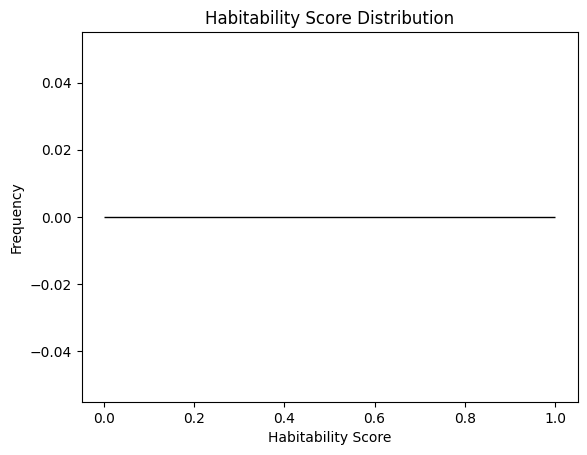

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(df["habitability_score"], kde=True)
plt.title("Habitability Score Distribution")
plt.xlabel("Habitability Score")
plt.ylabel("Frequency")
plt.show()


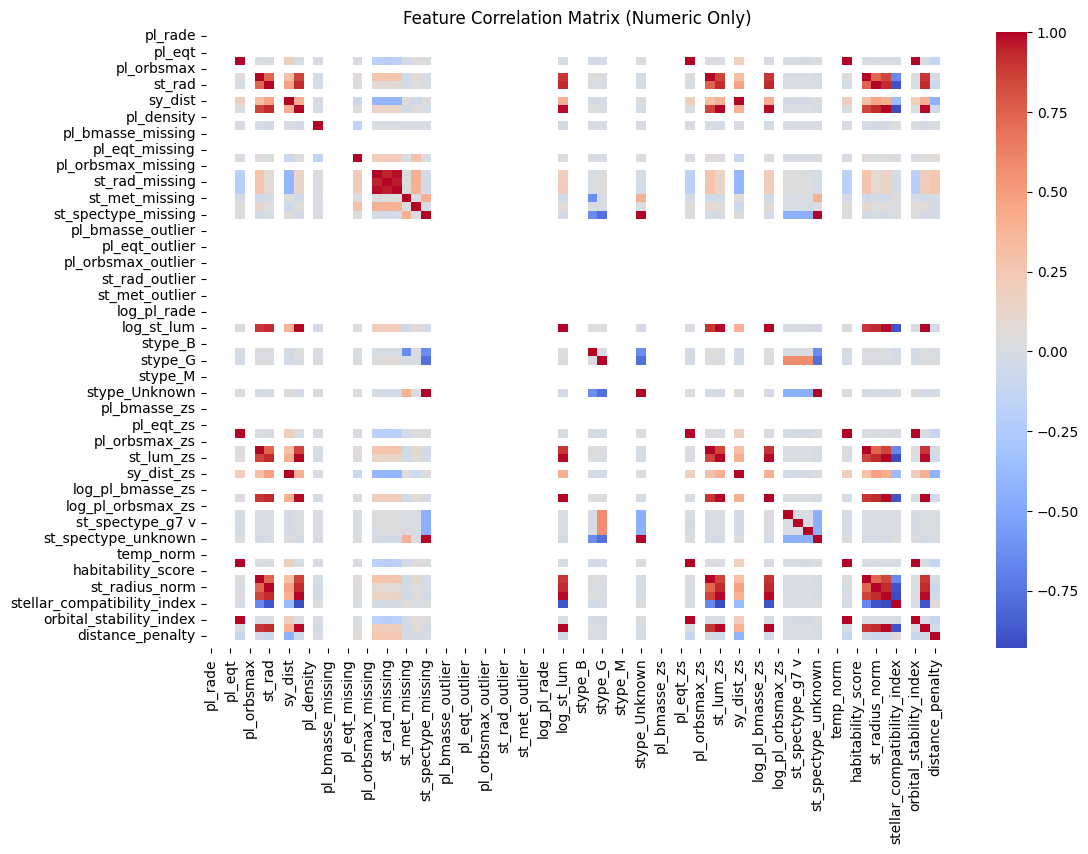

In [13]:
# =========================================
# Correlation on numeric columns only
# =========================================

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Feature Correlation Matrix (Numeric Only)")
plt.show()


In [14]:
# Show columns with NaNs and their counts
nan_cols = df.isnull().sum()
nan_cols[nan_cols > 0]


radius_norm           2534
temp_norm             2534
habitability_score    2534
dtype: int64

In [15]:
def safe_minmax(series):
    min_val = series.min()
    max_val = series.max()
    
    if max_val == min_val:
        return np.zeros(len(series))  # neutral normalization
    else:
        return (series - min_val) / (max_val - min_val)


In [16]:
# Recompute normalized features safely
df["radius_norm"] = safe_minmax(df["pl_rade"])
df["temp_norm"]   = safe_minmax(df["pl_eqt"])
df["orbit_norm"]  = safe_minmax(df["pl_orbper"])

# Recompute Habitability Score
df["habitability_score"] = (
    0.4 * (1 - df["radius_norm"]) +
    0.4 * (1 - abs(df["temp_norm"] - 0.5)) +
    0.2 * (1 - df["orbit_norm"])
)


In [17]:
# Fill remaining NaNs with neutral values
df[["radius_norm", "temp_norm", "orbit_norm", "habitability_score"]] = (
    df[["radius_norm", "temp_norm", "orbit_norm", "habitability_score"]]
    .fillna(0.5)
)


In [19]:
FEATURES = [
    "pl_rade",
    "pl_bmasse",
    "pl_eqt",
    "pl_orbper",
    "st_teff",
    "st_rad"
]

X = df[FEATURES]
y = df["habitability_score"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = XGBRegressor(...)
model.fit(X_scaled, y)

joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")


NameError: name 'XGBRegressor' is not defined

In [18]:
df.isnull().sum().sum()


np.int64(0)